<a href="https://colab.research.google.com/github/fajartria/ChurnMLPred/blob/main/Churn_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## General Workflow
### 1) Identifying Business Problem
### 2) Data Preprocessing
### 3) Exploratory Data Analysis (EDA)
### 4) Model Development & Evaluation
### 5) Model Interpretability

### 1) Identifying Business Problem

In this case, we're asked to develop a churn prediction develop model for a telecommunication company. This model will be used to predict customer churn within a given dataset. The model will be trained based on the previously available data which contains more than 15 features and its label (whether a customer churned or not)

The model is expected to have a good performance and high interpretability. In addition, the result of the model (customer that is predicted to be churning) will receive further treatment by the marketing department.

### 2) Data Preprocessing

In [ ]:
# Import Pandas for data manipulation purposes 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#Decision TREES
from sklearn.tree import DecisionTreeClassifier

# regularized regression with Ridge absolute value alpha
from sklearn.linear_model import Lasso


#for confusion matrix
from sklearn.metrics import confusion_matrix
#for having clasification reports
from sklearn.metrics import classification_report
#ROC curve for analyzing Logistic regression
from sklearn.metrics import roc_curve
# Cross Validation Score
from sklearn.model_selection import cross_val_score
# Calculate AUC Score
from sklearn.metrics import roc_auc_score

In [ ]:
# Reading file

# URL to training data
url_train = "https://raw.githubusercontent.com/fajartria/ChurnMLPred/main/Data-20211102/churn_train.csv"

# read using pandas read_csv
df_train = pd.read_csv(url_train)

In [ ]:
# Inspect the Data
df_train.info()

# Check the first 5 Rows of the Data
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


We can see that there are around 4k data with 20 columns (19 features and 1 target). The data does not contain null values.

As we will be developing a Machine learning Model, it is better to drop the state and area_code column and exclude them from the analysis (logically speaking these 2 features doesn't impact a prediction). A one hot encoder will also be needed for international_plan, voice_mail_plan and churn column.

In [ ]:
# Drop the columns we dont need

df_train.drop('state', axis=1, inplace=True)
df_train.drop('area_code', axis=1, inplace=True)

# Re-inspect the Data
df_train.info()

# Check the first 5 Rows of the Data
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_length                 4250 non-null   int64  
 1   international_plan             4250 non-null   object 
 2   voice_mail_plan                4250 non-null   object 
 3   number_vmail_messages          4250 non-null   int64  
 4   total_day_minutes              4250 non-null   float64
 5   total_day_calls                4250 non-null   int64  
 6   total_day_charge               4250 non-null   float64
 7   total_eve_minutes              4250 non-null   float64
 8   total_eve_calls                4250 non-null   int64  
 9   total_eve_charge               4250 non-null   float64
 10  total_night_minutes            4250 non-null   float64
 11  total_night_calls              4250 non-null   int64  
 12  total_night_charge             4250 non-null   f

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,121,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


### 3) Exploratory Data Analysis (EDA)

In this step, we're going to explore what our data tells us. We're going to analyse whether if the features are correlated, if certain group of customers are churning more compared to others, and so on.

### What are the correlation between all the features?

Theoretically, some features within our dataset should already have some kind of positive correlation. For example, the total number of calls, total minutes of calls, and the total charge should be related to each other.

It might be possible to, instead of using all of them for developing a model, to just use one of them since they are related to each other. But we will investigate more about this during the model evaluation process

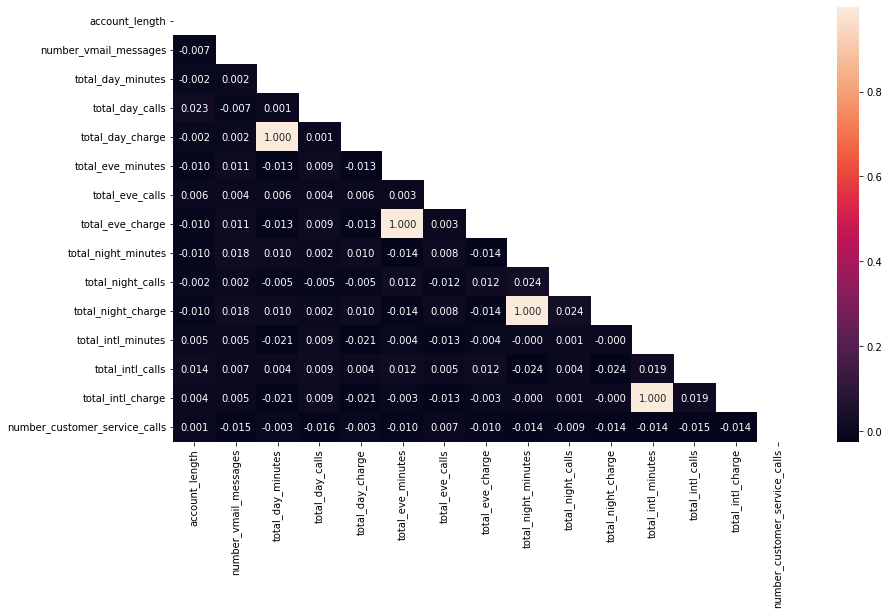

In [ ]:
# Correlation Matrix

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Compute the correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Heatmap
fig = plt.figure(figsize=(14,8))
sns.heatmap(corr, annot = True,  fmt='.3f', mask = mask)
plt.show()

From the graph above we can see clearly most of the features doesn't have any correlation with it. What's interesting here is that there is a really strong positive correlation between the total charge and total minutes, and this applies to all 3 different times (day, evening, night). This goes along with our logical sense which is a total charge will depend on how long does a customer spend time in a call. This means that only 1 feature out of the 2 will be used to develop our model. 

### Is there a relation between Number of CS calls and churn?

One of the thing that might be interesting to investigate is whether a higher number of CS calls leads to a higher churn. Some business assumption here is that when a customer make a lot of CS calls, it might be the customer is having a problem, and a customer with a problem will have a higher probability to churn.

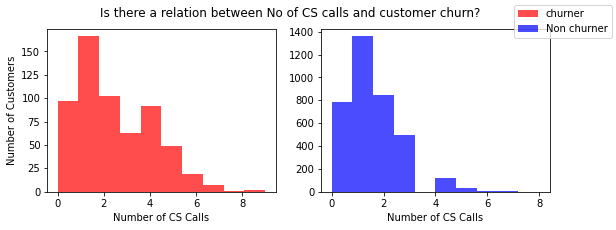

In [ ]:
# Import Matplotlib for Visualisation purposes
from matplotlib import pyplot as plt

# Splitting the Data into Churners and Non Churners
C = df_train[df_train["churn"] == "yes"]
NC = df_train[df_train["churn"] == "no"]

# Define new variables for plotting
x = C["number_customer_service_calls"]
x1 = NC["number_customer_service_calls"]
y = C["churn"]

# Plot
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].hist(x, color = 'r', alpha=0.7, label = 'churner')
axs[1].hist(x1, color = 'b', alpha=0.7, label = 'Non churner')
fig.suptitle('Is there a relation between No of CS calls and customer churn?')
axs[0].set_xlabel('Number of CS Calls')
axs[1].set_xlabel('Number of CS Calls')
axs[0].set_ylabel('Number of Customers')
fig.legend()
plt.show()

At a glance, there seem to be no difference between the Non churners and the churners. They have different total number of customers but that is because we have more Non churners in our dataset. But if we take a look closely on the high Number of CS calls, we could see that the churners have made a slightly more CS calls.

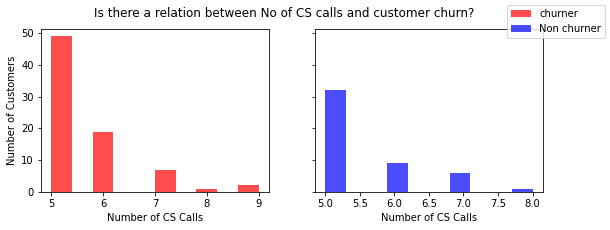

In [ ]:
# Splitting the Data into Churners and Non Churners, also only select customers with more than 4 CS Calls
C = df_train[(df_train["churn"] == "yes") & (df_train["number_customer_service_calls"] > 4)]
NC = df_train[(df_train["churn"] == "no") & (df_train["number_customer_service_calls"] > 4)]

# Define new variables for plotting
x = C["number_customer_service_calls"]
x1 = NC["number_customer_service_calls"]
y = C["churn"]

# Plot
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey = True)
axs[0].hist(x, color = 'r', alpha=0.7, label = 'churner')
axs[1].hist(x1, color = 'b', alpha=0.7, label = 'Non churner')
fig.suptitle('Is there a relation between No of CS calls and customer churn?')
axs[0].set_xlabel('Number of CS Calls')
axs[1].set_xlabel('Number of CS Calls')
axs[0].set_ylabel('Number of Customers')
fig.legend()
plt.show()

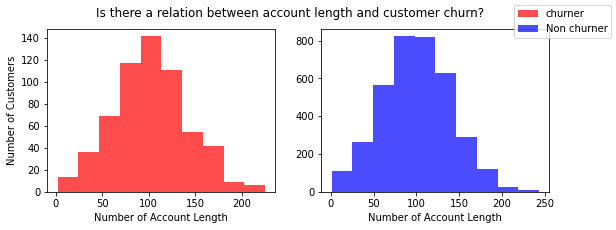

In [ ]:
# Import Matplotlib for Visualisation purposes
from matplotlib import pyplot as plt

# Splitting the Data into Churners and Non Churners
C = df_train[df_train["churn"] == "yes"]
NC = df_train[df_train["churn"] == "no"]

# Define new variables for plotting
x = C["account_length"]
x1 = NC["account_length"]
y = C["churn"]

# Plot
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].hist(x, color = 'r', alpha=0.7, label = 'churner')
axs[1].hist(x1, color = 'b', alpha=0.7, label = 'Non churner')
fig.suptitle('Is there a relation between account length and customer churn?')
axs[0].set_xlabel('Number of Account Length')
axs[1].set_xlabel('Number of Account Length')
axs[0].set_ylabel('Number of Customers')
fig.legend()
plt.show()

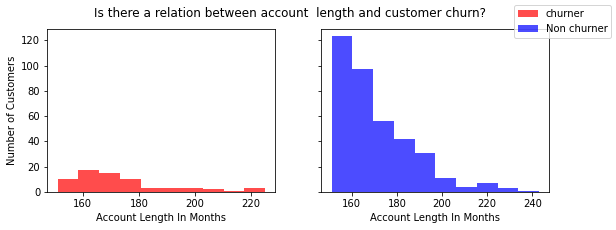

In [ ]:
# Splitting the Data into Churners and Non Churners, also only select customers with more than 200 account length
C = df_train[(df_train["churn"] == "yes") & (df_train["account_length"] > 150)]
NC = df_train[(df_train["churn"] == "no") & (df_train["account_length"] > 150)]

# Define new variables for plotting
x = C["account_length"]
x1 = NC["account_length"]
y = C["churn"]

# Plot
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey = True)
axs[0].hist(x, color = 'r', alpha=0.7, label = 'churner')
axs[1].hist(x1, color = 'b', alpha=0.7, label = 'Non churner')
fig.suptitle('Is there a relation between account  length and customer churn?')
axs[0].set_xlabel('Account Length In Months')
axs[1].set_xlabel('Account Length In Months')
axs[0].set_ylabel('Number of Customers')
fig.legend()
plt.show()

### 4) Model Development & Evaluation

In this step, we're going to train a model based on the training set. From this training set, the model created will also be validated using cross validation.

In [ ]:
# Little processing before feeding the data into the model

# Define label encoding
dictionary = {"yes": 1, "no": 0}

# Replace values in the Data
df_train = df_train.replace({"churn": dictionary, "international_plan": dictionary, "voice_mail_plan": dictionary})

df_train.head()
x_lasso=df_train.drop(['churn'],axis=1)
y_lasso=df_train['churn']

From the previous correlation matrix, we know that total charge and total minutes are perfectly correlated, so we will only use one of them to build our model. We're going to choose the total charge because it has less variance within our dataset

In [ ]:
# Combine similar columns into one
df_train['total_charge'] =  df_train['total_day_charge'] + df_train['total_eve_charge'] + df_train['total_night_charge'] + df_train['total_intl_charge']
df_train['total_calls'] = df_train['total_day_calls'] + df_train['total_eve_calls'] + df_train['total_night_calls'] + df_train['total_intl_calls']

df_train.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_charge,total_calls
0,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,59.24,332
1,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,62.29,333
2,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,66.80,255
3,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,52.09,359
4,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,78.31,321


In [ ]:
# Keep only the columns that we're going to use
columns_to_keep = ['account_length', 'international_plan', 'voice_mail_plan', 'number_customer_service_calls', 'total_charge', 'total_calls', 'churn']

df_train = df_train[columns_to_keep]

df_train.head()

,account_length,international_plan,voice_mail_plan,number_customer_service_calls,total_charge,total_calls,churn
0,107,0,1,1,59.24,332,0
1,137,0,0,0,62.29,333,0
2,84,1,0,2,66.80,255,0
3,75,1,0,3,52.09,359,0
4,121,0,1,3,78.31,321,0


### Linear Model

In [ ]:
# Define X and y

X = df_train.iloc[:, :6]
y = df_train['churn']

In [ ]:
## Instantiate a lasso regressor: lasso with normalize
lasso_norm = Lasso(alpha=0.4)

# Fit the regressor to the data
lasso_norm.fit(X,y)

# Compute and print the coefficients
lasso_coef_norm = lasso_norm.fit(X,y).coef_
print(lasso_coef_norm)

[ 0.          0.         -0.          0.          0.00425508 -0.        ]


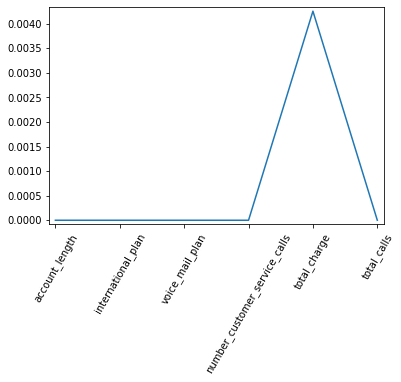

In [ ]:
# Plot the coefficients
plt.plot(range(len(X.columns)), lasso_coef_norm)
plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
plt.margins(0.02)
plt.show()

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
train_accuracy = np.empty(len(solvers))
test_accuracy = np.empty(len(solvers))

In [ ]:
np.random.seed(613)
X_train,X_val,y_train,y_val =train_test_split(X,y,stratify = y, test_size=0.2, random_state= 42)

# Loop over different values of k
for i in range(1,len(solvers)):
    logs=LogisticRegression(solver=solvers[i])

    # Fit the classifier to the training data
    logs.fit(X_train,y_train)

    #Compute accuracy on the training set
  
    train_accuracy[i] = logs.score(X_train, y_train)
    
    #Compute accuracy on the training set
    test_accuracy[i] = logs.score(X_val,y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


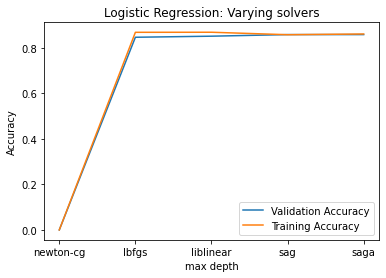

In [ ]:
plt.title('Logistic Regression: Varying solvers')
plt.plot(solvers, test_accuracy, label = 'Validation Accuracy')
plt.plot(solvers, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
np.random.seed(613)
X_train,X_val,y_train,y_val=train_test_split(X,y, stratify = y, test_size=0.2)

In [ ]:
logreg = LogisticRegression(solver='lbfgs')
logreg = logreg.fit(X_train,y_train)
y_reg_pred=logreg.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print(classification_report(y_val, y_reg_pred))
scores = cross_val_score(logreg, X, y, cv=5)
scores

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       730
           1       0.53      0.20      0.29       120

    accuracy                           0.86       850
   macro avg       0.71      0.59      0.61       850
weighted avg       0.83      0.86      0.83       850



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([0.86823529, 0.85764706, 0.86352941, 0.86941176, 0.86588235])

In [ ]:
y_pred_prob = logreg.predict_proba(X_val)[:,1]
fpr,tpr,thresholds=roc_curve(y_val,y_pred_prob)
logreg.coef_

array([[ 1.80629379e-03,  2.21722198e+00, -1.05967672e+00,
         5.63068932e-01,  7.94921547e-02, -7.60820802e-04]])

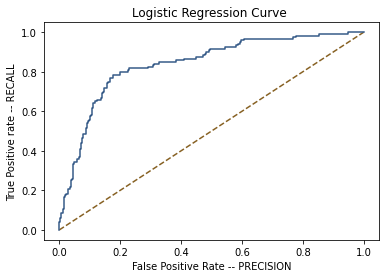

In [ ]:
plt.plot([0,1],[0,1],'k--', color="#876123")
plt.plot(fpr,tpr,color='#345987')
plt.xlabel("False Positive Rate -- PRECISION")
plt.ylabel("True Positive rate -- RECALL")
plt.title("Logistic Regression Curve ")
plt.show()


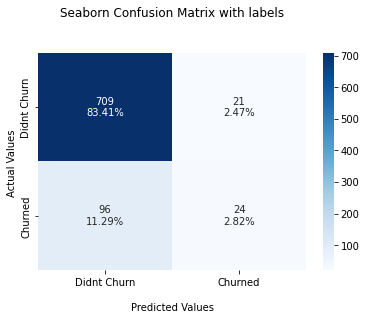

In [ ]:
### Source: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

#Generate the confusion matrix

cf_matrix = confusion_matrix(y_val, np.round(y_pred_prob))

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

# Plot correlation Matrix
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Didnt Churn','Churned'])
ax.yaxis.set_ticklabels(['Didnt Churn','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Blackbox Model (Random Forest)

In [ ]:
# define Model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)

# Set Features & Target
X = df_train.iloc[:, :6]
y = df_train['churn']

In [ ]:
# Use cross validation to Evaluate Model
scores = cross_val_score(rf, X, y, cv=5)
scores

array([0.94470588, 0.94941176, 0.95294118, 0.96235294, 0.94941176])

In [ ]:
from sklearn.metrics import r2_score, accuracy_score
from scipy.stats import spearmanr, pearsonr

In [ ]:
rfs = np.arange(1, 11)
train_accuracy = np.empty(len(rfs))
test_accuracy = np.empty(len(rfs))

In [ ]:
np.random.seed(613)
X_train,X_val,y_train,y_val =train_test_split(X,y,stratify = y, test_size=0.2, random_state= 42)

# Loop over different values 
for i in range (0,10):
    # Setup a RF Classifier 
    rfss=RandomForestClassifier(n_estimators=100, max_depth=i+1, random_state=42)

    # Fit the classifier to the training data
    rfss.fit(X_train,y_train)
    predicted_train = rfss.predict(X_train)
    predicted_test = rfss.predict(X_val)

    test_accuracy[i] = accuracy_score(y_val, predicted_test)
    
    #Compute accuracy on the training set
    train_accuracy[i] = accuracy_score(y_train,predicted_train)


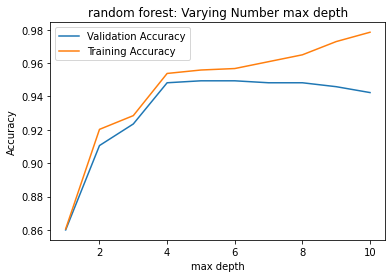

In [ ]:
plt.title('random forest: Varying Number max depth')
plt.plot(rfs, test_accuracy, label = 'Validation Accuracy')
plt.plot(rfs, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
rfs_per_pop=[]
rfs_fpr=[]
rfs_tpr=[]
rfs_tresh=[]

In [ ]:
X_train,X_val,y_train,y_val =train_test_split(X,y,stratify = y, test_size=0.2, random_state= 42)

for i in range(2,10):
  for j in range(100,300,100):

    rfs=RandomForestClassifier(n_estimators=j, max_depth=i, random_state=42)
    rf = rf.fit(X_train,y_train)
    y_pred_prob = rf.predict_proba(X_val)[:,1]
    # fpr,tpr,thresholds=roc_curve(y_val,y_pred_prob)
    # rfs_per_pop.append(y_pred_prob)
    # rfs_fpr.append(fpr)
    # rfs_tpr.append(tpr)
    # rfs_tresh.append(thresholds)



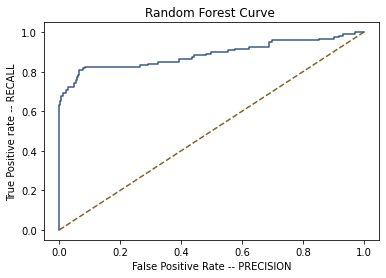

In [ ]:
# Split Data into Validation and Training

X_train,X_val,y_train,y_val =train_test_split(X,y,stratify = y, test_size=0.2, random_state= 42)

rf = rf.fit(X_train,y_train)

# Predict on the validation set
y_pred_prob = rf.predict_proba(X_val)[:,1]

# Construct ROC 
fpr,tpr,thresholds=roc_curve(y_val,y_pred_prob)

plt.plot([0,1],[0,1],'k--', color="#876123")
plt.plot(fpr,tpr,color='#345987')
plt.xlabel("False Positive Rate -- PRECISION")
plt.ylabel("True Positive rate -- RECALL")
plt.title("Random Forest Curve ")
plt.show()

In [ ]:
# Evaluate Feature importances
pd.DataFrame(rf.feature_importances_, index=X.columns, columns=["Feature importance"]).sort_values('Feature importance', ascending = False)

,Feature importance
total_charge,0.564001
number_customer_service_calls,0.195148
international_plan,0.105399
voice_mail_plan,0.074762
total_calls,0.031361
account_length,0.029329


In [ ]:
# Calculate AUC score

auc_val = roc_auc_score(y_val, np.round(y_pred_prob))
auc_val

0.8243150684931506

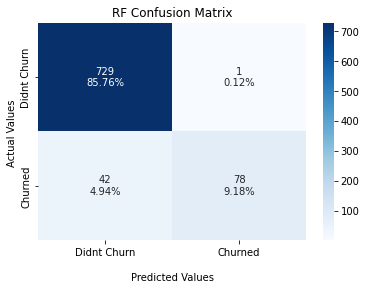

In [ ]:
### Source: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/


from sklearn.metrics import confusion_matrix

#Generate the confusion matrix

cf_matrix = confusion_matrix(y_val, np.round(y_pred_prob))

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

# Plot correlation Matrix
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('RF Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Didnt Churn','Churned'])
ax.yaxis.set_ticklabels(['Didnt Churn','Churned'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
clf_list = [
    (logreg, "Logistic"),
    (rf, "Random forest"),
]

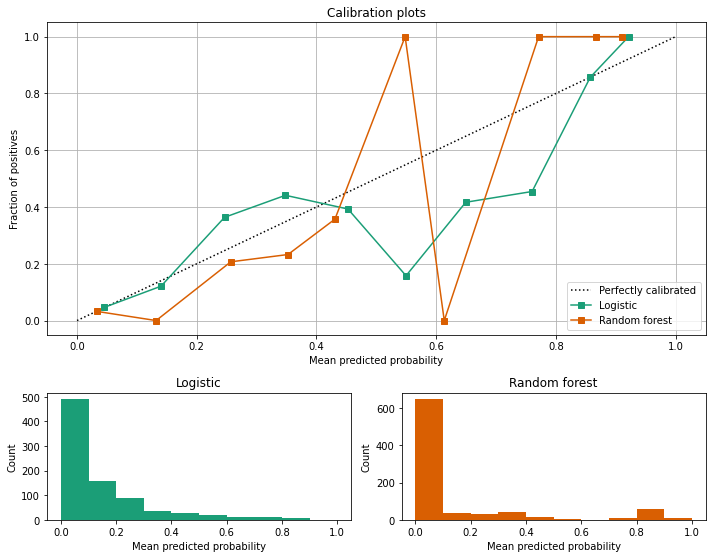

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

### 5) Model Interpretability

In this step, we're going to test the trained model with the actual, unseen test set. From this test set, we're going to interpret the result with the interpretability techniques.

In [ ]:
# Reading file

# URL to training data
url_test = "https://raw.githubusercontent.com/fajartria/ChurnMLPred/main/Data-20211102/churn_test.csv"

# read using pandas read_csv
df_test = pd.read_csv(url_test)

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          750 non-null    object 
 1   account_length                 750 non-null    int64  
 2   area_code                      750 non-null    object 
 3   international_plan             750 non-null    object 
 4   voice_mail_plan                750 non-null    object 
 5   number_vmail_messages          750 non-null    int64  
 6   total_day_minutes              750 non-null    float64
 7   total_day_calls                750 non-null    int64  
 8   total_day_charge               750 non-null    float64
 9   total_eve_minutes              750 non-null    float64
 10  total_eve_calls                750 non-null    int64  
 11  total_eve_charge               750 non-null    float64
 12  total_night_minutes            750 non-null    flo

In [ ]:
# Process the Test Data

# Define label encoding
dictionary = {"yes": 1, "no": 0}

# Replace values in the Data
df_test = df_test.replace({"international_plan": dictionary, "voice_mail_plan": dictionary})

# Combine similar columns into one
df_test['total_charge'] =  df_test['total_day_charge'] + df_test['total_eve_charge'] + df_test['total_night_charge'] + df_test['total_intl_charge']
df_test['total_calls'] = df_test['total_day_calls'] + df_test['total_eve_calls'] + df_test['total_night_calls'] + df_test['total_intl_calls']

columns_to_keep = ['account_length', 'international_plan', 'voice_mail_plan', 'number_customer_service_calls', 'total_charge', 'total_calls']

df_test = df_test[columns_to_keep]

df_test.head()

,account_length,international_plan,voice_mail_plan,number_customer_service_calls,total_charge,total_calls
0,128,0,1,1,75.56,303
1,118,1,0,0,67.61,323
2,62,0,0,4,59.31,251
3,93,0,0,3,58.99,349
4,174,0,0,3,60.15,308


In [ ]:
# reference: https://htmlpreview.github.io/?https://github.com/DanaJomar/PyALE/blob/master/examples/ALE%20plots%20for%20classification%20models.html
def ale(target=None, print_meanres=False, **kwargs):
    if target is not None:
        class clf():
            def __init__(self, classifier):
                self.classifier = classifier
            def predict(self, X):
                return(self.classifier.predict_proba(X)[:, target])
        clf_dummy = clf(kwargs["model"])
        kwargs["model"] = clf_dummy
    if (print_meanres & len(kwargs["feature"])==1):
        mean_response = np.mean(kwargs["model"].predict(kwargs["X"]), axis=0)
        print(f"Mean response: {mean_response:.5f}")
    return PyALE.ale(**kwargs)

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(estimator=logreg, X=df_test, features=[3, 4, (3, 4), 1, (1,3)], ax=ax)
fig.tight_layout(pad=2.0)

In [ ]:
from sklearn.inspection import plot_partial_dependence


plot_partial_dependence(logreg, df_test, [3, 4, (3, 4), 1, (1,3)])

plt.show()

### Logistic Regression Model

In [ ]:
# Use our previous model to do the prediction

pred_test = logreg.predict(df_test)

#Add predicted result to original dataframe
df_test['churn_prediction_logreg'] = pred_test

In [ ]:
#!pip install shap

import shap
shap.initjs()

     |████████████████████████████████| 371 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509243 sha256=dc43e9b367ca5ececaf7a52b96632d6765890615cc939a5fc152d2930f04a95f
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
X_test = df_test.iloc[:, :6]

# set up explainer for ".predict" method
explainer = shap.Explainer(logreg.predict, X_test)

# compute shap values
shap_values = explainer(X_test)

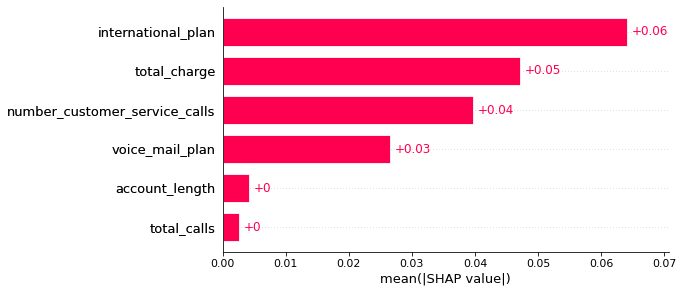

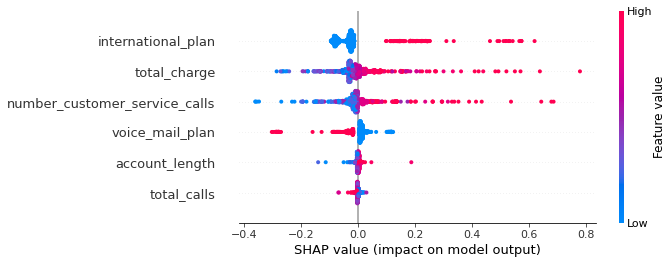

In [ ]:
# feature importance (global)

# bar chart
shap.plots.bar(shap_values)

# individual dots for each instance
shap.plots.beeswarm(shap_values)

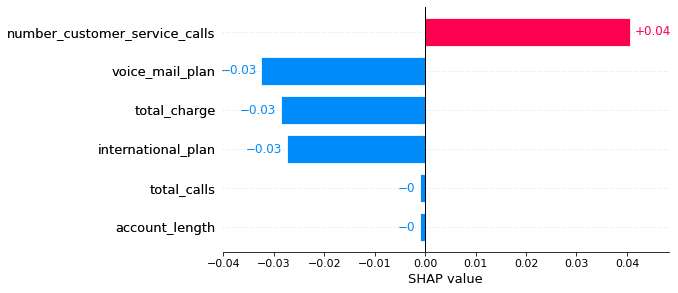

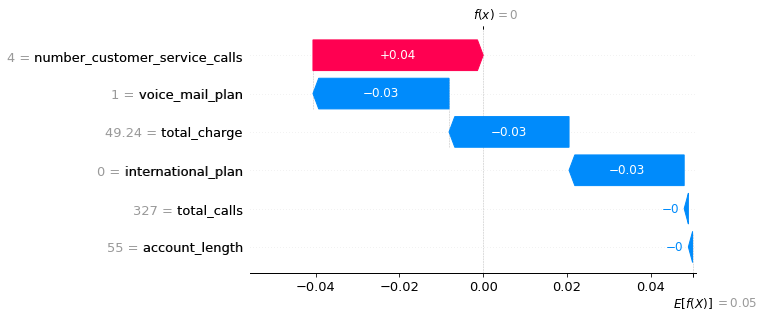

In [ ]:
# explain individual instance (local)
instance = 200

# feature importance
shap.plots.bar(shap_values[instance])

# contribution to output
shap.plots.waterfall(shap_values[instance])

### Random Forest Model

In [ ]:
# Use our previous model to do the prediction

pred_test = rf.predict(df_test.iloc[:, :6])

#Add predicted result to original dataframe
df_test['churn_prediction_rf'] = pred_test

In [ ]:
!pip install shap

import shap
shap.initjs()

     |████████████████████████████████| 371 kB 6.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509233 sha256=d7922d82b989bfd13804e9dd9191ee0cf762fdef95b33d8ebc1b8f83de6bf1c3
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
X_test = df_test.iloc[:, :6]

# set up explainer for ".predict" method
explainer = shap.Explainer(rf.predict, X_test)

# compute shap values
shap_values = explainer(X_test)

Exact explainer: 751it [00:56, 11.62it/s]


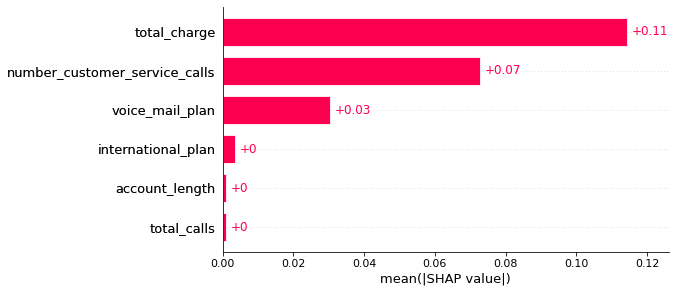

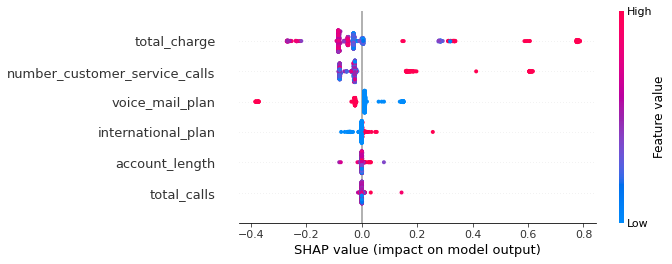

In [ ]:
# feature importance (global)

# bar chart
shap.plots.bar(shap_values)

# individual dots for each instance
shap.plots.beeswarm(shap_values)

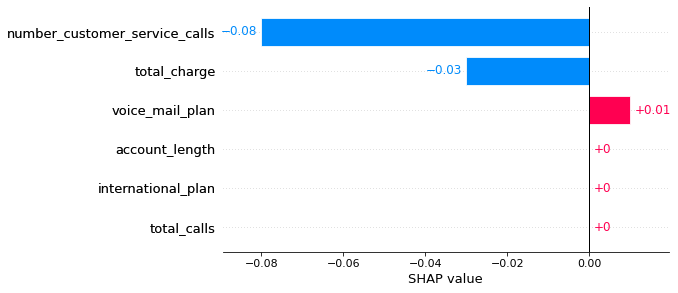

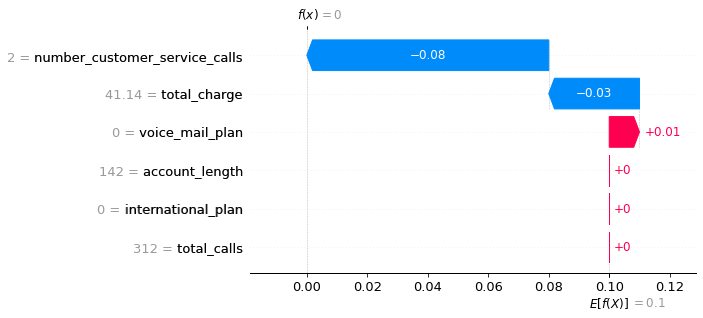

In [ ]:
# explain individual instance (local)
instance = 5

# feature importance
shap.plots.bar(shap_values[instance])

# contribution to output
shap.plots.waterfall(shap_values[instance])

In [ ]:
# initialize explainer
explainer = shap.Explainer(rf)

# compute shapley values 
shap_values = explainer.shap_values(X_test)

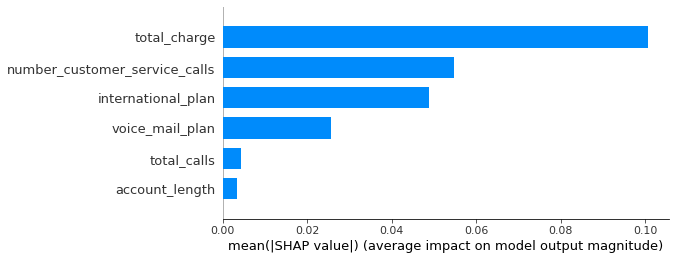

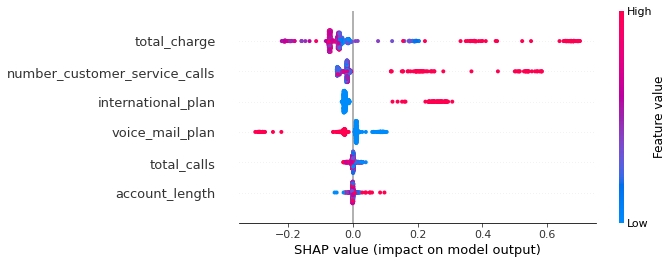

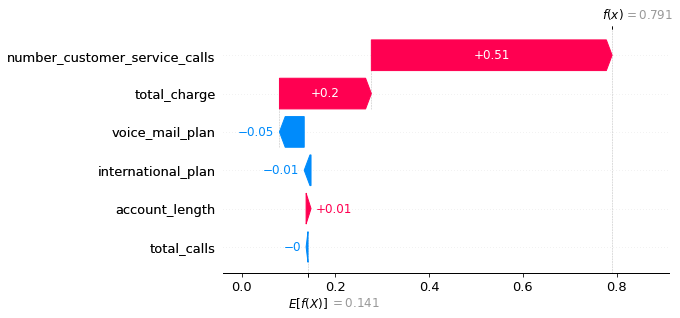

In [ ]:
# feature importance for individual instances (and class)

target = 1
instance = 200


# distribution of shapley values for target (global)
shap.summary_plot(shap_values[target], X_test, plot_type="bar")
shap.summary_plot(shap_values[target], X_test, plot_type="dot")

# inspect feature contributions for individual instances (local)
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[target], shap_values[target][instance], feature_names=X_test.columns)

In [ ]:
# Define label encoding
dictionary = {1: "yes", 0: "no"}

# Replace values in the Data
Final_Data = df_test.replace({"churn_prediction_rf": dictionary,"international_plan": dictionary, "voice_mail_plan": dictionary, "churn_prediction_logreg": dictionary})

# Final Result
Final_Data

,account_length,international_plan,voice_mail_plan,number_customer_service_calls,total_charge,total_calls,churn_prediction_logreg,churn_prediction_rf
0,128,no,yes,1,75.56,303,no,no
1,118,yes,no,0,67.61,323,no,no
2,62,no,no,4,59.31,251,no,no
3,93,no,no,3,58.99,349,no,no
4,174,no,no,3,60.15,308,no,no
...,...,...,...,...,...,...,...,...
745,130,no,no,0,51.71,314,no,no
746,73,no,no,3,67.31,316,no,no
747,152,no,no,3,66.72,278,no,no
748,61,no,no,1,51.82,318,no,no


In [ ]:
# Comparing performance of the 4 models

performance = {'Model': ['Logistic Regression', 'Random Forest'], 
               'Accuracy (%)': [86, 95], 
               'Sensitivity (%)': [65, 20], 
               'Specificity (%)': [100, 97]
              }
perf = pd.DataFrame(data=performance)
perf = perf.set_index('Model')
perf

,Accuracy (%),Sensitivity (%),Specificity (%)
Model,,,
Logistic Regression,86,65,100
Random Forest,95,20,97


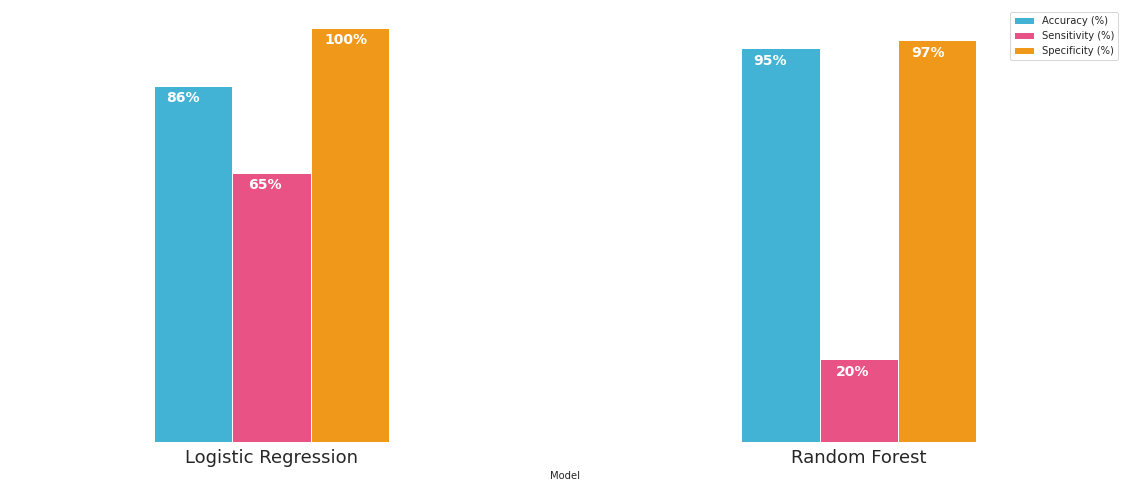

In [ ]:
sns.set_style(style='white')

ax = perf.plot(kind='bar', figsize=(20,8), width=0.4, color=['#42b3d5', '#e85285', '#f09819'], fontsize=18)

ax.legend(loc='best')
plt.xticks(rotation=0, ha="center")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(False)
ax.spines['left'].set_linewidth(False)

ax.get_yaxis().set_visible(False)

for n in range(3):
    for index, val in enumerate(perf.iloc[:,n].transpose()): 
        label=str(val) + '%'
        
        if n==0:
            ax.annotate(label, xy=(index - 0.18, val-4), color='#ffffff', fontsize=14, fontweight='bold')
        elif n==1:
            ax.annotate(label, xy=(index - 0.04, val-4), color='#ffffff', fontsize=14, fontweight='bold')
        elif n==2:
            ax.annotate(label, xy=(index + 0.09, val-4), color='#ffffff', fontsize=14, fontweight='bold')

In [ ]:
Sumpred = {'Model': ['Logistic Regression', 'Random Forest'], 
               'Churners': [18, 68], 
               'Non Churners': [732, 682]
              }
Sum = pd.DataFrame(data=Sumpred)
Sum = Sum.set_index('Model')
Sum

,Churners,Non Churners
Model,,
Logistic Regression,18,732
Random Forest,68,682


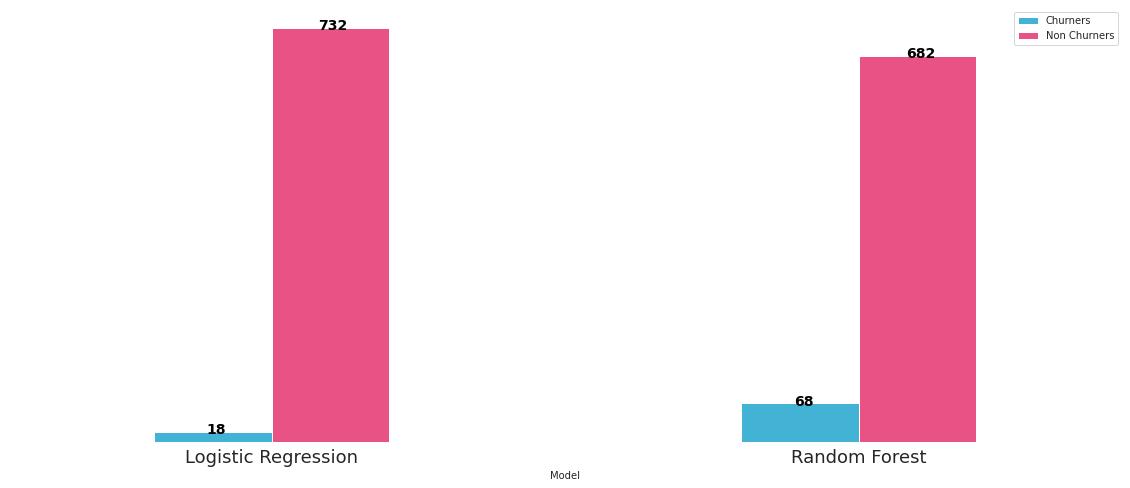

In [ ]:
sns.set_style(style='white')

ax = Sum.plot(kind='bar', figsize=(20,8), width=0.4, color=['#42b3d5', '#e85285', '#f09819'], fontsize=18)

ax.legend(loc='best')
plt.xticks(rotation=0, ha="center")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(False)
ax.spines['left'].set_linewidth(False)

ax.get_yaxis().set_visible(False)

for n in range(2):
    for index, val in enumerate(Sum.iloc[:,n].transpose()): 
        label=str(val) 
        
        if n==0:
            ax.annotate(label, xy=(index - 0.11, val-4), color='black', fontsize=14, fontweight='bold')
        elif n==1:
            ax.annotate(label, xy=(index + 0.08, val-4), color='black', fontsize=14, fontweight='bold')